In [1]:
#!pip install --upgrade ~/Development/repos/tradeframework
#!pip install --upgrade ~/Development/repos/quantutils

# import utilities
from MIPriceAggregator.api.aggregator import MarketDataAggregator
import quantutils.dataset.pipeline as ppl

#import tradeframework
from tradeframework.api import Derivative, Optimizer, Model, TradeEnvironment, TradeEngine, Asset
from tradeframework.environments import SandboxEnvironment, ZiplineEnvironment
from tradeframework.models import PreOpenMomentum
import tradeframework.operations.trader as trader

import pandas as pd
import numpy as np
import quantutils.core.timeseries as tsUtils

import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)


In [2]:
data_config = [
    {
        "ID": "yahoo",
        "class": "YahooConnector",
        "opts": {
            "interval":"1d"
        },
        "timezone":"UTC",
        "markets": [
            {
                "ID": "DOW",
                "sources": [
                    {
                        "ID":"^DJI",
                        "sample_unit":"D"
                    }
                ]
            },
            {
                "ID": "S&P",
                "sources": [
                    {
                        "ID":"^GSPC",
                        "sample_unit":"D"
                    }
                ]
            }
        ]

    },
    {
        "ID": "MDS",
        "class": "MDSConnector",
        "opts": {
            "remote":True,
            "location":"http://pricestore.192.168.1.203.nip.io"
        },
        "timezone":"UTC",
        "markets": [
            {
                "ID": "DOW",
                "sources": [
                     {
                        "ID": "WallSt-hourly",
                        "sample_unit": "H"
                    },
                    {
                        "ID": "D&J-IND",
                        "sample_unit": "5min"
                    }
                ]
            }
        ]

    }
]

data_config = [
    {
        "ID": "MDS",
        "class": "MDSConnector",
        "opts": {
            "remote":True,
            "location":"http://pricestore.192.168.1.203.nip.io"
        },
        "timezone":"UTC",
        "markets": [
            {
                "ID": "DOW",
                "sources": [
                    {
                        "ID": "D&J-IND",
                        "sample_unit": "5min"
                    }
                ]
            }
            
        ]

    }
]

## Get Market Data
aggregator = MarketDataAggregator(data_config)
   
start = "2013-01-01"
end = "2020-07-11"

ts = aggregator.getData( "DOW", "H", start, end, debug=True)
ts = ts.reset_index().set_index("Date_Time")[["Open", "High", "Low", "Close"]]
ts = ppl.removeNaNs(ts)
ts = ts.tz_convert("US/Eastern", level=0)


Resampling to 5min periods
Resampling to H periods
Resampling to H periods


In [3]:
dir = "../unittest"
asset1 = Asset("DOW", pd.read_csv(dir + '/data/testData1.csv', parse_dates=True, index_col=0, dayfirst=True))
asset2 = Asset("SPY", pd.read_csv(dir + '/data/testData2.csv', parse_dates=True, index_col=0, dayfirst=True))
asset1.values

,Open,Close
Date,,
2018-01-01,100.000000,100.000000
2018-01-02,80.000000,80.000000
2018-01-03,88.000000,88.000000
2018-01-04,70.400000,70.400000
2018-01-05,77.440000,77.440000
2018-01-06,61.952000,61.952000
2018-01-07,68.147200,68.147200
2018-01-08,54.517760,54.517760
2018-01-09,59.969536,59.969536


In [4]:
# randomSignals = TODO Pick random numbers between -1 and 1 and round to nearest integer.
randomSignals = np.array([1, 1, 0, -1, 0, -1, 1, -1, 0])

class RandomModel(Model):

    def getSignals(self, window, idx=0):
        loc = window.index.get_loc(idx)
        window = window[idx:]
        signals = pd.DataFrame(np.array([np.zeros(len(window)), randomSignals[loc:loc + len(window)]]).T, index=window.index, columns=["bar", "gap"])
        return signals

dir = "../unittest"
A1 = Asset("DOW", pd.read_csv(dir + '/data/testData1.csv', parse_dates=True, index_col=0, dayfirst=True))
A2 = Asset("SPY", pd.read_csv(dir + '/data/testData2.csv', parse_dates=True, index_col=0, dayfirst=True))

        
# Create portfolio
env = SandboxEnvironment("TradeFair")
asset1 = env.append(Asset("DOW"))
asset2 = env.append(Asset("SPY"))

p = env.setPortfolio(
    env.createDerivative("MyPortfolio", weightGenerator=env.createOptimizer("EqualWeightsOptimizer"))
    .addAsset(
        env.createDerivative("Test-BuyAndHold", weightGenerator=env.createModel("BuyAndHold"))
        .addAsset(asset1)
    )
    .addAsset(
        env.createDerivative("Test-Random", weightGenerator=RandomModel(env, window=-1))
        .addAsset(asset2)
    )
)

env.append(A1, refreshPortfolio=False)
env.append(A2, refreshPortfolio=False)
env.refresh(A1.values.index[0])

            Open  Close
Date                   
2018-01-01  99.0    0.0
2018-01-02  -0.2    0.0
2018-01-03   0.1    0.0
2018-01-04  -0.2    0.0
2018-01-05   0.1    0.0
2018-01-06  -0.2    0.0
2018-01-07   0.1    0.0
2018-01-08  -0.2    0.0
2018-01-09   0.1    0.0
            Open  Close
Date                   
2018-01-01  99.0    0.0
2018-01-02   0.2    0.0
2018-01-03  -0.1    0.0
2018-01-04   0.2    0.0
2018-01-05  -0.1    0.0
2018-01-06   0.2    0.0
2018-01-07  -0.1    0.0
2018-01-08   0.2    0.0
2018-01-09  -0.1    0.0


In [14]:
trader.getUnderlyingAllocations(p)["DOW"]["gap"].values

array([0.005     , 0.00625   , 0.00568182, 0.00639205, 0.00639205,
       0.00719105, 0.00719105, 0.00898881, 0.00898881])

In [131]:
def getUnderlyingAllocations(derivative):

    currentAllocations = derivative.getAllocations()

    myUAllocations = None
    if (currentAllocations is not None):
        # Derivative
        assetCount = len(currentAllocations.columns.levels[0])
        for l1 in range(assetCount):
            uAllocations = getUnderlyingAllocations(derivative.assets[l1])
            for l2 in uAllocations.columns.levels[0]:
                assetUAllocation = uAllocations[l2] * \
                    currentAllocations[
                    currentAllocations.columns.levels[0][l1]].values
                if (myUAllocations is None):
                    myUAllocations = pd.DataFrame(
                        assetUAllocation.values, index=assetUAllocation.index, columns=[[l2, l2], ['bar', 'gap']])
                elif (l2 in myUAllocations.columns.levels[0]):
                    myUAllocations[l2] += assetUAllocation
                else:
                    myUAllocations = pd.concat(
                        [myUAllocations, pd.DataFrame(assetUAllocation.values, index=assetUAllocation.index, columns=[[l2, l2], ['bar', 'gap']])], axis=1)

    else:
        # Asset
        myUAllocations = pd.DataFrame(
            np.ones((len(derivative.values), 2)),
            columns=[[derivative.name, derivative.name], ['bar', 'gap']],
            index=derivative.values.index
        )

    return myUAllocations

In [6]:
#Trade if price is higher/lower than daily MA

class MovingAverage(Model):
    def __init__(self, name, env, periods):
        Model.__init__(self, name, env)
        self.window = periods 
        self.periods = periods
        return
    
    def getSignals(self, idx=0):
        
        window = self.getWindow(idx)
        
        resample = window.resample("B", label="left", closed="left").apply({"Open":"first", "High":"max", "Low":"min", "Close":"last"}).dropna()
       
        st_osc = tsUtils.stoch_osc(resample, self.periods)
        
        resample_signals = np.nan_to_num(np.sign(st_osc["%K"] - st_osc["%D"]), 0)
        resample_signals = np.roll(raw_signals, 1)
        resample_signals[0] = 0
        
        resample_signals = pd.DataFrame(np.array([resample_signals, resample_signals]).T, resample.index, columns=["bar","gap"])

        signals = resample_signals.resample("H").ffill()
        signals = signals[signals.index.isin(window.index)]
        signals = signals.append(pd.DataFrame({"bar":resample_signals.iloc[-1]["bar"], "gap":resample_signals.iloc[-1]["gap"]}, index=window[window.index > signals.index[-1]].index))

        return signals[idx:]
    

In [7]:
import quantutils.core.timeseries as tsUtils
import tradeframework.operations.trader as trader

# Trade if return was bigger than 2 std move

class TwoStdDev(Model):
    def __init__(self, name, env, start=None, end=None):
        Model.__init__(self, name, env)
        self.start = start
        self.end = end
        self.env
        return
    
    def getSignals(self, context, assetInfo):
        
        signals = pd.DataFrame(np.zeros((len(assetInfo.values), 2)), index=assetInfo.values.index, columns=["bar","gap"])
        
        ret =  np.log((trader.getPeriodReturns(assetInfo.returns) + 1))
        
        ma = pd.DataFrame(tsUtils.MA(ret, 20, 10), ret.index)
        std = pd.DataFrame(tsUtils.MStd(ret, 20, 10), ret.index)
        b1 = ma + 2*std
        b2 = ma - 2*std
        
        signals["bar"][(ret > b1[0]) | (ret<b2[0])] = np.sign(ret[(ret > b1[0]) | (ret<b2[0])])
        signals = signals.shift(1)
        signals.iloc[0] = 0
        
        return signals

In [19]:
bEnv = SandboxEnvironment("TradeFair", "UTC")
baseline = bEnv.setPortfolio(
    bEnv.createDerivative("Baseline", weightGenerator=bEnv.createOptimizer("EqualWeightsOptimizer"))
    .addAsset(
        bEnv.createDerivative("Baseline", weightGenerator=bEnv.createModel("BuyAndHold"))
        .addAsset(bEnv.append(Asset("DOW", ts)))
    )
)

bEnv.refresh()

In [20]:
env = SandboxEnvironment("TradeFair", "US/Eastern")

#opt = env.createOptimizer("KellyOptimizer", "KellyOpt", opts={"window":40*24, "weight":.01})
p = env.createDerivative("MyPortfolio", weightGenerator=env.createOptimizer("EqualWeightsOptimizer", opts={"weight":1.0}))
env.setPortfolio(p)

# Non-Weighted Portfolio (Indicator)
#indicatorP = env.createPortfolio("Indicators")
#p.addAsset(indicatorP, weighted=False)
#indicatorP.addAsset(env.createModel( "TrendFollowingIndicator", "TrendFollowing", opts={"start": "15:00", "end": "16:00", "barOnly": True} ))
#indicatorP.addAsset(env.createModel( "MA20", "MovingAverage", opts={"ma1_win":20} ))
#indicatorP.addAsset(env.createModel( "MAXOver", "MovingAverageXOver", opts={"ma1_fast":50, "ma2_slow":200} ))
#indicatorP.addAsset(env.createModel( "MADailyX", "MovingAverageResampleXOver", opts={"ma1_fast":1, "ma2_slow":20, "src_sample":"H", "tgt_sample":"W"} ))
#indicatorP.addAsset(env.createModel( "StochOSC1", "StochasticOscXOver", opts={"window":14, "src_sample":"H", "tgt_sample":"W-MON" } ))
#indicatorP.addAsset(env.createModel( "StochOSC2", "StochasticOscXOver", opts={"window":14, "src_sample":"H", "tgt_sample":"D"} ))
#indicatorP.addAsset(env.createModel( "StochOSC3", "StochasticOscXOver", opts={"window":14, "src_sample":"H", "tgt_sample":"H"} ))
#indicatorP.addAsset(env.createModel( "BuyAndHoldIndicator", "BuyAndHold" ))

#p.addAsset(MovingAverage("MA20", env, 14))

# Combination Model (using Indicators)
#p.addAsset(env.createModel("CombiTrendAndBuy", "CombinationModel", opts={"modelList": [ "StochOSC1", "StochOSC2", "BuyAndHoldIndicator"]}))

# Custom Models
#p.addAsset(env.createModel( "D1-PreOpenMomentum", "PreOpenMomentum" ))
#p.addAsset(env.createModel( "MA20", "MovingAverage", opts={"ma1_win":20} ))
#p.addAsset(env.createModel( "MAX", "MovingAverageXOver", opts={"ma1_fast":50, "ma2_slow":200} ))
#p.addAsset(env.createModel( "MADaily", "MovingAverageResample", opts={"ma1_win":200, "src_sample":"H", "tgt_sample":"B"} ))
#p.addAsset(env.createModel( "MADailyX", "MovingAverageResampleXOver", opts={"ma1_fast":1, "ma2_slow":12, "src_sample":"H", "tgt_sample":"MS"} ))
#p.addAsset(env.createModel( "MADailyX2", "MovingAverageResampleXOver", opts={"ma1_fast":4, "ma2_slow":52, "src_sample":"H", "tgt_sample":"W-MON"} ))
#p.addAsset(env.createModel( "MADailyX2", "MovingAverageResampleXOver", opts={"ma1_fast":50, "ma2_slow":200, "src_sample":"H", "tgt_sample":"D"} ))
#p.addAsset(env.createModel( "StochOSC", "StochasticOscXOver", opts={"window":9, "src_sample":"D", "tgt_sample":"W-MON"} ))

# All hours
#p.addAsset(env.createModel( "D2-BuyAndHold", "BuyAndHold"))

# Market Opening hours only
#p.addAsset(env.createModel( "D3-BuyAndHold7", "BuyAndHold", opts={"start":"09:00", "end":"16:00"}))

# Individual hours
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold6", args=("10:00", "11:00")))
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold5", args=("11:00", "12:00")))
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold4", args=("12:00", "13:00")))
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold3", args=("13:00", "14:00")))
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold2", args=("14:00", "15:00")))
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold1", args=("15:00", "16:00")))
d = env.createDerivative("TestModel", weightGenerator=env.createModel("TrendFollowing", opts={"start": "15:00", "end": "16:00", "barOnly": True}))

# ML models
threshold = 0
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-BasicBootstrap_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '4892e256e17f4fad775119304ee7e6d1', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-BasicBootstrap_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', '4892e256e17f4fad775119304ee7e6d1', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-BasicBoosting_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '83c0ff9eeb24c87dbb0af766ab59ef75', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-BasicBoosting_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', '83c0ff9eeb24c87dbb0af766ab59ef75', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-OneStepAhead_Boosting_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', 'f2efe64bbc39ad0880337120f32ca12b', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-OneStepAhead_Boosting_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', 'f2efe64bbc39ad0880337120f32ca12b', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-OneStepAhead_Bootstrap_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', '078df5a1afbaa2290ee93b4a562e3898', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-OneStepAhead_Bootstrap_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '078df5a1afbaa2290ee93b4a562e3898', threshold)))

#Sandbox
#p.addAsset(env.createModel( "D3-BuyAndHold7", "BuyAndHold"))
#p.addAsset(env.createModel( "D3-BuyAndHold7", "SellAndHold", opts={"start":"09:00", "end":"16:00", "barOnly":"True"}))

# Feed data into the portfolio
p.addAsset(d.addAsset(env.append(Asset("DOW", ts))))
env.refresh()



(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb910e179b0>)

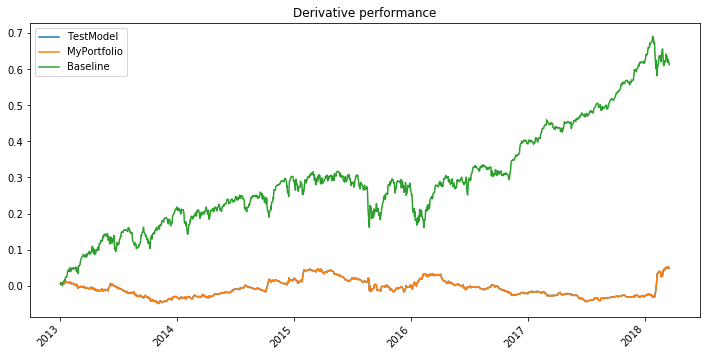

In [21]:
import tradeframework.operations.plot as plotter
#tInfo = env.getTradingInfo(context, dInfo, 10000)
plotter.plotReturns(p, baseline, includeComponents=True, includePrimary=True, log=True)

In [14]:
import tradeframework.operations.plot as plotter
#tInfo = env.getTradingInfo(context, dInfo, 10000)
chart = plotter.plotUnderlying(p, "S&P")

/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


AttributeError: 'NoneType' object has no attribute 'getName'

In [15]:
dInfo.values[["Open","Close"]].values.flatten().T

array([1.        , 1.02540342, 1.02540342, ..., 2.8470471 , 2.84234228,
       2.85415003])

In [19]:
dInfo.returns

,Open,Close
Date_Time,,
2013-01-02 00:00:00+00:00,0.000000,0.025403
2013-01-03 00:00:00+00:00,0.000000,-0.002086
2013-01-04 00:00:00+00:00,0.000000,0.004865
2013-01-07 00:00:00+00:00,0.000000,-0.003123
2013-01-08 00:00:00+00:00,0.000000,-0.003242
...,...,...
2023-01-23 00:00:00+00:00,0.001392,0.010475
2023-01-24 00:00:00+00:00,-0.004495,0.003801
2023-01-25 00:00:00+00:00,-0.008524,0.008414


In [7]:
import tradeframework.operations.plot as plotter
#tInfo = env.getTradingInfo(context, dInfo, 10000)
plotter.plotUnderlying(dInfo, "S&P")

/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [11]:
import tradeframework.operations.plot as plotter
#tInfo = env.getTradingInfo(context, dInfo, 10000)
plotter.plotWeightedUnderlying(dInfo.assets[1], "S&P")

In [160]:
trader.getCurrentSignal(p, 10000)

{'timestamp': '2013-07-10T14:00:00-04:00',
 'value': 0.999403167721637,
 'capital': 10000,
 'target': 'CLOSE',
 'markets': [{'name': 'DOW',
   'price': 15336.06,
   'signal': 'HOLD',
   'amount': 0.0}]}

In [108]:
import tradeframework.operations.utils as utils
x = ts[11:12].copy()
print(x)
#x["Close"] = np.nan
#x["High"] = np.nan
#x["Low"] = np.nan

possibles = []

for i in range(0,30):
    ohlc = [[x["Open"].values[0] + i, np.nan, np.nan, np.nan]]
    index = x.index
    possibles.append(utils.createAssetFromOHLC(index, ohlc, "DOW"))
    
trader.predictSignals(env, possibles, 10000)

                               Open      High       Low     Close
Date_Time                                                        
2013-01-02 22:00:00+00:00  13412.55  13412.55  13412.55  13412.55


[{'timestamp': '2013-07-10T22:00:00+00:00',
  'value': 0.9920758142487437,
  'capital': 10000,
  'target': 'CLOSE',
  'markets': [{'name': 'DOW',
    'price': 15291.66,
    'signal': 'HOLD',
    'amount': 0.0}]},
 {'timestamp': '2013-07-10T22:00:00+00:00',
  'value': 0.9920758142487437,
  'capital': 10000,
  'target': 'CLOSE',
  'markets': [{'name': 'DOW',
    'price': 15291.66,
    'signal': 'HOLD',
    'amount': 0.0}]},
 {'timestamp': '2013-07-10T22:00:00+00:00',
  'value': 0.9920758142487437,
  'capital': 10000,
  'target': 'CLOSE',
  'markets': [{'name': 'DOW',
    'price': 15291.66,
    'signal': 'HOLD',
    'amount': 0.0}]},
 {'timestamp': '2013-07-10T22:00:00+00:00',
  'value': 0.9920758142487437,
  'capital': 10000,
  'target': 'CLOSE',
  'markets': [{'name': 'DOW',
    'price': 15291.66,
    'signal': 'HOLD',
    'amount': 0.0}]},
 {'timestamp': '2013-07-10T22:00:00+00:00',
  'value': 0.9920758142487437,
  'capital': 10000,
  'target': 'CLOSE',
  'markets': [{'name': 'DOW',
  

In [3]:
ohlc = [[17407.46, 13411.91, 13377.22, 17387.45]]
index = pd.DatetimeIndex(['2013-07-10 15:00:00'], tz='US/Eastern') # TODO: Provide UK timezone

trader.predictSignals(env, utils.createAssetFromOHLC(index, ohlc, "DOW"), 10000)

NameError: name 'pd' is not defined

In [219]:
possibles = []

for i in range(-10,10):
    ohlc = [[15274.38 + i, np.nan, np.nan, np.nan]]
    index = pd.DatetimeIndex(['2013-07-10 15:00:00'], tz='US/Eastern')
    possibles.append(utils.createAssetFromOHLC(index, ohlc, "DOW"))
    
x = trader.predictSignals(env, possibles, 10000)

In [220]:
x[10]

[{'timestamp': '2013-07-10T15:00:00-04:00',
  'value': 0.9912554640452014,
  'capital': 10000,
  'target': 'OPEN',
  'markets': [{'name': 'DOW',
    'price': 15264.38,
    'signal': 'SELL',
    'amount': 0.6493912389793765}]},
 {'timestamp': '2013-07-10T15:00:00-04:00',
  'value': 0.9912554640452014,
  'capital': 10000,
  'target': 'OPEN',
  'markets': [{'name': 'DOW',
    'price': 15265.38,
    'signal': 'SELL',
    'amount': 0.6493486988500787}]},
 {'timestamp': '2013-07-10T15:00:00-04:00',
  'value': 0.9912554640452014,
  'capital': 10000,
  'target': 'OPEN',
  'markets': [{'name': 'DOW',
    'price': 15266.38,
    'signal': 'SELL',
    'amount': 0.6493061642938283}]},
 {'timestamp': '2013-07-10T15:00:00-04:00',
  'value': 0.9912554640452014,
  'capital': 10000,
  'target': 'OPEN',
  'markets': [{'name': 'DOW',
    'price': 15267.38,
    'signal': 'SELL',
    'amount': 0.6492636353095301}]},
 {'timestamp': '2013-07-10T15:00:00-04:00',
  'value': 0.9912554640452014,
  'capital': 1000

In [224]:
x[10]

{'timestamp': '2013-07-10T15:00:00-04:00',
 'value': 0.9912554640452014,
 'capital': 10000,
 'target': 'OPEN',
 'markets': [{'name': 'DOW',
   'price': 15274.38,
   'signal': 'HOLD',
   'amount': 0.0}]}

In [23]:
x = trader.getTradingInfo(p,1, summary=False)
x[-1:].values[0][1]

0.9912554640452014

In [30]:
trader.getTradingInfo(p,10000, unitAllocations=False)

MyPortfolio                     DOW            \
                                Capital                   Price             
                                   Open         Close      Open     Close   
2013-01-02 15:00:00-05:00  10000.000000  10047.532859  13331.83  13395.20   
2013-01-03 15:00:00-05:00  10047.532859  10069.192226  13406.38  13377.48   
2013-01-04 15:00:00-05:00  10069.192226  10077.506245  13419.10  13430.18   
2013-01-07 15:00:00-05:00  10077.506245  10078.553059  13381.30  13382.69   
2013-01-08 15:00:00-05:00  10078.553059  10067.892634  13311.48  13325.56   
2013-01-09 15:00:00-05:00  10067.892634  10048.245526  13364.34  13390.42   
2013-01-10 15:00:00-05:00  10048.245526  10054.749351  13456.73  13465.44   
2013-01-11 15:00:00-05:00  10054.749351  10057.815431  13478.13  13482.24   
2013-01-14 15:00:00-05:00  10057.815431  10053.877297  13510.42  13505.13   
2013-01-15 15:00:00-05:00  10053.877297  10067.993231  13518.24  13537.22   
2013-01-16 15:00:00-05:00  10067.993231  10063.828214  13512.57  13506.98   
2013-01-17 15:00:00-05:00  10063.828214  10075.117822  13620.96  13605.68   
2013-01-18 15:00:00-05:00  10075.117822  10098.765466  13608.09  13640.03   
2013-01-22 15:00:00-05:00  10098.765466  10102.443705  13700.26  13705.25   
2013-01-23 15:00:00-05:00  10102.443705  10092.796070  13790.86  13777.69   
2013-01-24 15:00:00-05:00  10092.796070  10095.920698  13824.74  13829.02   
2013-01-25 15:00:00-05:00  10095.920698  10088.309625  13874.96  13885.42   
2013-01-28 15:00:00-05:00  10088.309625  10075.778068  13902.91  13885.64   
2013-01-29 15:00:00-05:00  10075.778068  10068.807576  13948.98  13958.63   
2013-01-30 15:00:00-05:00  10068.807576  10086.985581  13930.60  13905.45   
2013-01-31 15:00:00-05:00  10086.985581  10104.442086  13896.94  13872.89   
2013-02-01 15:00:00-05:00  10104.442086  10100.753883  13999.69  14004.80   
2013-02-04 15:00:00-05:00  10100.753883  10071.841824  13915.06  13875.23   
2013-02-05 15:00:00-05:00  10071.841824  10050.006929  14004.24  13973.88   
2013-02-06 15:00:00-05:00  10050.006929  10064.214632  13963.35  13983.09   
2013-02-07 15:00:00-05:00  10064.214632  10062.150123  13942.13  13939.27   
2013-02-08 15:00:00-05:00  10062.150123  10062.315616  13984.29  13984.06   
2013-02-11 15:00:00-05:00  10062.315616  10052.266759  13958.67  13972.61   
2013-02-12 15:00:00-05:00  10052.266759  10060.641928  14030.88  14019.19   
2013-02-13 15:00:00-05:00  10060.641928  10040.285963  13952.27  13980.50   
...                                 ...           ...       ...       ...   
2013-05-24 15:00:00-04:00   9879.278022   9882.888629  15295.26  15300.85   
2013-05-28 15:00:00-04:00   9882.888629   9885.267509  15412.93  15416.64   
2013-05-29 15:00:00-04:00   9885.267509   9889.294539  15317.51  15311.27   
2013-05-30 15:00:00-04:00   9889.294539   9849.600043  15391.57  15329.79   
2013-05-31 15:00:00-04:00   9849.600043   9910.931762  15238.91  15144.02   
2013-06-03 15:00:00-04:00   9910.931762   9947.709875  15193.23  15249.61   
2013-06-04 15:00:00-04:00   9947.709875   9972.061811  15143.01  15180.08   
2013-06-05 15:00:00-04:00   9972.061811   9996.124530  14993.70  14957.52   
2013-06-06 15:00:00-04:00   9996.124530  10034.864878  14973.41  15031.44   
2013-06-07 15:00:00-04:00  10034.864878  10059.948213  15210.32  15248.34   
2013-06-10 15:00:00-04:00  10059.948213  10036.930829  15262.09  15227.17   
2013-06-11 15:00:00-04:00  10036.930829   9996.308435  15182.99  15121.54   
2013-06-12 15:00:00-04:00   9996.308435  10004.660861  15008.06  14995.52   
2013-06-13 15:00:00-04:00  10004.660861  10042.316314  15123.05  15179.97   
2013-06-14 15:00:00-04:00  10042.316314  10035.201764  15060.90  15071.57   
2013-06-17 15:00:00-04:00  10035.201764   9999.390877  15126.69  15180.67   
2013-06-18 15:00:00-04:00   9999.390877   9987.418682  15334.60  15316.24   
2013-06-19 15:00:00-04:00   9987.418682  10003.336962  15152.15  15128.00   
2013-06-20 15:00:00-04:0

In [14]:
trader.getTradingInfo(p,10000)

MyPortfolio                     DOW            \
                                Capital                   Price             
                                   Open         Close      Open     Close   
Date_Time                                                                   
2013-01-02 15:00:00-05:00  10000.000000  10047.532859  13331.83  13395.20   
2013-01-03 15:00:00-05:00  10047.532859  10069.192226  13406.38  13377.48   
2013-01-04 15:00:00-05:00  10069.192226  10077.506245  13419.10  13430.18   
2013-01-07 15:00:00-05:00  10077.506245  10078.553059  13381.30  13382.69   
2013-01-08 15:00:00-05:00  10078.553059  10067.892634  13311.48  13325.56   
2013-01-09 15:00:00-05:00  10067.892634  10048.245526  13364.34  13390.42   
2013-01-10 15:00:00-05:00  10048.245526  10054.749351  13456.73  13465.44   
2013-01-11 15:00:00-05:00  10054.749351  10057.815431  13478.13  13482.24   
2013-01-14 15:00:00-05:00  10057.815431  10053.877297  13510.42  13505.13   
2013-01-15 15:00:00-05:00  10053.877297  10067.993231  13518.24  13537.22   
2013-01-16 15:00:00-05:00  10067.993231  10063.828214  13512.57  13506.98   
2013-01-17 15:00:00-05:00  10063.828214  10075.117822  13620.96  13605.68   
2013-01-18 15:00:00-05:00  10075.117822  10098.765466  13608.09  13640.03   
2013-01-22 15:00:00-05:00  10098.765466  10102.443705  13700.26  13705.25   
2013-01-23 15:00:00-05:00  10102.443705  10092.796070  13790.86  13777.69   
2013-01-24 15:00:00-05:00  10092.796070  10095.920698  13824.74  13829.02   
2013-01-25 15:00:00-05:00  10095.920698  10088.309625  13874.96  13885.42   
2013-01-28 15:00:00-05:00  10088.309625  10075.778068  13902.91  13885.64   
2013-01-29 15:00:00-05:00  10075.778068  10068.807576  13948.98  13958.63   
2013-01-30 15:00:00-05:00  10068.807576  10086.985581  13930.60  13905.45   
2013-01-31 15:00:00-05:00  10086.985581  10104.442086  13896.94  13872.89   
2013-02-01 15:00:00-05:00  10104.442086  10100.753883  13999.69  14004.80   
2013-02-04 15:00:00-05:00  10100.753883  10071.841824  13915.06  13875.23   
2013-02-05 15:00:00-05:00  10071.841824  10050.006929  14004.24  13973.88   
2013-02-06 15:00:00-05:00  10050.006929  10064.214632  13963.35  13983.09   
2013-02-07 15:00:00-05:00  10064.214632  10062.150123  13942.13  13939.27   
2013-02-08 15:00:00-05:00  10062.150123  10062.315616  13984.29  13984.06   
2013-02-11 15:00:00-05:00  10062.315616  10052.266759  13958.67  13972.61   
2013-02-12 15:00:00-05:00  10052.266759  10060.641928  14030.88  14019.19   
2013-02-13 15:00:00-05:00  10060.641928  10040.285963  13952.27  13980.50   
...                                 ...           ...       ...       ...   
2013-05-28 15:00:00-04:00   9882.888629   9885.267509  15412.93  15416.64   
2013-05-29 15:00:00-04:00   9885.267509   9889.294539  15317.51  15311.27   
2013-05-30 15:00:00-04:00   9889.294539   9849.600043  15391.57  15329.79   
2013-05-31 15:00:00-04:00   9849.600043   9910.931762  15238.91  15144.02   
2013-06-03 15:00:00-04:00   9910.931762   9947.709875  15193.23  15249.61   
2013-06-04 15:00:00-04:00   9947.709875   9972.061811  15143.01  15180.08   
2013-06-05 15:00:00-04:00   9972.061811   9996.124530  14993.70  14957.52   
2013-06-06 15:00:00-04:00   9996.124530  10034.864878  14973.41  15031.44   
2013-06-07 15:00:00-04:00  10034.864878  10059.948213  15210.32  15248.34   
2013-06-10 15:00:00-04:00  10059.948213  10036.930829  15262.09  15227.17   
2013-06-11 15:00:00-04:00  10036.930829   9996.308435  15182.99  15121.54   
2013-06-12 15:00:00-04:00   9996.308435  10004.660861  15008.06  14995.52   
2013-06-13 15:00:00-04:00  10004.660861  10042.316314  15123.05  15179.97   
2013-06-14 15:00:00-04:00  10042.316314  10035.201764  15060.90  15071.57   
2013-06-17 15:00:00-04:00  10035.201764   9999.390877  15126.69  15180.67   
2013-06-18 15:00:00-04:00   9999.390877   9987.418682  15334.60  15316.24   
2013-06-19 15:00:00-04:00   9987.418682  10003.336962  15152.15  15128.00   
2013-06-20 15:00:00-04:0

(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5dc6fed320>)

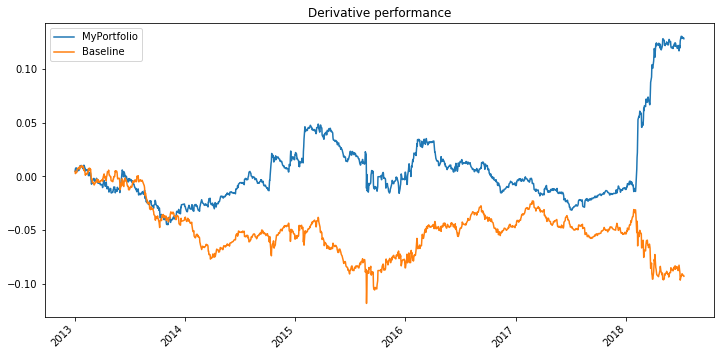

In [5]:
# MODEL: p.addModel(env.createModel("TrendFollowing", "TF7", args=("15:00", "16:00", True)))
#
# TODO - Notice how the simple trend following model works well when the market volatility changes in 2018. A 
# property of the market "stretching" so that the medium term (in this case bi-hourly) trends hit their sweet spot. 
# Earlier when volatility is lower and market is "compacted", the target trend term is longer (maybe 4-hourly). This 
# could be achieved with a MA with a dynamic window, or by dynamically modifying the time sample sizes. 

# TODO - The visualisation of the basline is misleading and does not show the cause of the performance (in this case the
# previous hours prices and the current hours prices, in a sequentional form). Perhaps we need to show period returns
# rather than daily returns (which is what getPeriodReturns provides)

trader.plot(p, baseline, includeComponents=False, includePrimary=True, log=True)

(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2a4effa0f0>)

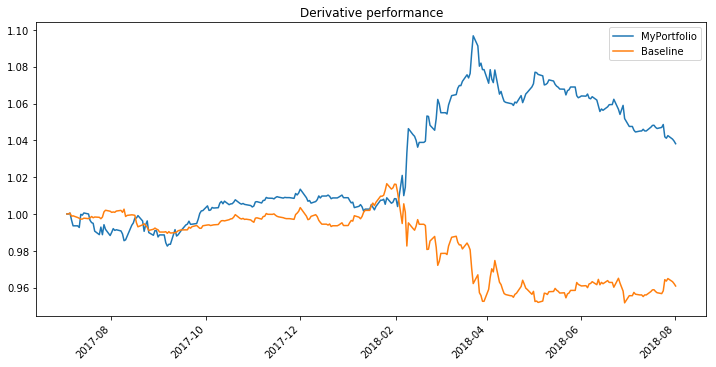

In [11]:
# TODO - EVEN MORE SUSPICIOUS PLOT - Why are Multiple Equally Weight MI signals generating the exact inverse of the baseline
# Sell signal until training period over (2000ish training set)?

import tradeframework.utils.trader as trader
#tInfo = env.getTradingInfo(context, dInfo, 10000)
trader.plot(p, baseline, includeComponents=False, includePrimary=True, log=False)

In [10]:
## import tradeframework.utils.trader as trader
tInfo = env.getTradingInfo(context, dInfo, 10000)
#fig, ax = trader.plot(dInfo.assets[0], includeComponents=False, includePrimary=False, log=False)

# Add Moving Average
import quantutils.core.timeseries as tsUtils
period = 20
offset = 10
ret =  np.log((trader.getPeriodReturns(baseline.assets[0].returns) + 1))

ma2 = pd.DataFrame(tsUtils.MA(np.cumsum(ret), period, offset), np.cumsum(ret).index)

ma1 = pd.DataFrame(tsUtils.MA(ret, period, offset), ret.index)
ma1.iloc[int(np.ceil(period/2+offset)-1)] =  np.cumsum(ma2).iloc[int(np.ceil(period/2+offset)-1)]

ma3 = pd.DataFrame(EMA(ret, period, offset), ret.index)
ma3.iloc[int(np.ceil(period/2+offset)-1)] = np.cumsum(ma2).iloc[int(np.ceil(period/2+offset)-1)]

# Bollinger Bands
b1 = ma1 + 2*pd.DataFrame(MStd(ret, period, offset), ret.index)
b2 = ma1 - 2*pd.DataFrame(MStd(ret, period, offset), ret.index)

#ax.plot(np.cumsum(ma1), label="MA=20")
#ax.plot(np.cumsum(ma2), 'ro', label="MA=20")
#ax.plot(np.cumsum(ma3), label="EMA=20")
#ax.plot(np.cumsum(ret),label="Return")
#ax.plot(np.cumsum(b1),label="Upper",color='b')
#ax.plot(np.cumsum(b2),label="Lower",color='b')
ax.plot(ret,label="Return")
ax.plot(ma1, label="MA=20")
ax.plot(b1,label="Upper",color='b')
ax.plot(b2,label="Lower",color='b')

signals = pd.DataFrame(np.zeros((len(baseline.assets[0].returns), 2)), index=baseline.assets[0].returns.index, columns=["bar","gap"])
signals["bar"][(ret > b1[0]) | (ret<b2[0])] = np.negative(np.sign(ret[(ret > b1[0]) | (ret<b2[0])]))
signals = signals.shift(1)
signals.iloc[0] = 0
print(signals[:10])

ax.legend(loc='best')
fig.canvas.draw()

/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/quantutils/core/timeseries.py:5: FutureWarning: Series.strides is deprecated and will be removed in a future version
  strides = a.strides + (a.strides[-1],)


NameError: name 'MStd' is not defined

In [171]:
s[(ret > b1[0]) | (ret<b2[0])] = ret[(ret > b1[0]) | (ret<b2[0])]
s[(ret > b1[0]) | (ret<b2[0])][:10]

Date_Time
2016-07-06 11:00:00-04:00   -0.0028989199
2016-07-06 12:00:00-04:00   -0.0027498755
2016-07-07 15:00:00-04:00    0.0038070757
2016-07-08 08:00:00-04:00   -0.0042140577
2016-07-10 22:00:00-04:00    0.0036564117
2016-07-12 04:00:00-04:00    0.0022138113
2016-07-12 11:00:00-04:00    0.0020186596
2016-07-13 09:00:00-04:00    0.0021459527
2016-07-14 02:00:00-04:00   -0.0041677510
2016-07-14 05:00:00-04:00    0.0036714130
Name: bar, dtype: float64

In [173]:
ret[(ret > b1[0]) | (ret<b2[0])][:10]

Date_Time
2016-07-06 11:00:00-04:00   -0.0028989199
2016-07-06 12:00:00-04:00   -0.0027498755
2016-07-07 15:00:00-04:00    0.0038070757
2016-07-08 08:00:00-04:00   -0.0042140577
2016-07-10 22:00:00-04:00    0.0036564117
2016-07-12 04:00:00-04:00    0.0022138113
2016-07-12 11:00:00-04:00    0.0020186596
2016-07-13 09:00:00-04:00    0.0021459527
2016-07-14 02:00:00-04:00   -0.0041677510
2016-07-14 05:00:00-04:00    0.0036714130
dtype: float64

/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/quantutils/core/timeseries.py:12: RuntimeWarning: invalid value encountered in multiply
  r = np.empty(len(values)) * np.nan


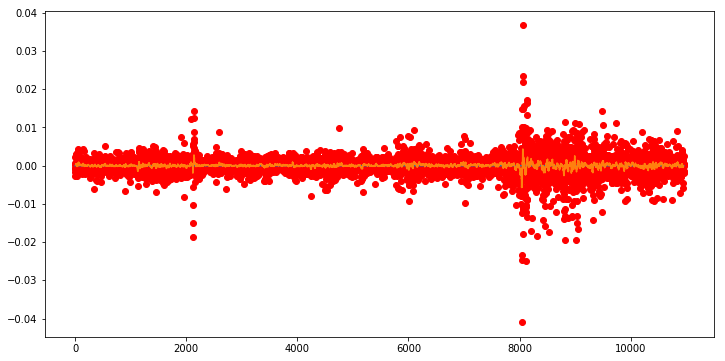

In [48]:
# Returns plot
from matplotlib import pyplot
x = np.diff(tInfo.values[:,0]/10000)
ma = tsUtils.MA(x, 20)
pyplot.plot(x,'ro')
pyplot.plot([0] * len(x))
pyplot.plot(ma)
pyplot.show()

/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/quantutils/core/timeseries.py:12: RuntimeWarning: invalid value encountered in multiply
  r = np.empty(len(values)) * np.nan


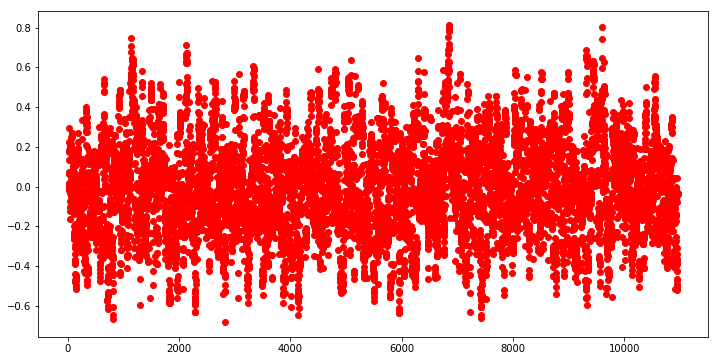

In [49]:
# Moving ACF plot
pyplot.plot(tsUtils.MACF(x, 1, 20, 10), 'ro')
pyplot.show()

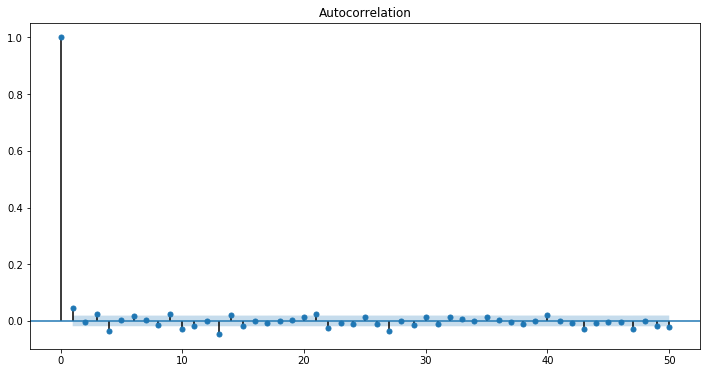

(-21.657623155825704,
 0.0,
 26,
 10932,
 {'1%': -3.430948320175338,
  '5%': -2.861804424408925,
  '10%': -2.566910747983175},
 -109835.06372657401)

In [36]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
plot_acf(x, lags=50)
pyplot.show()
adfuller(x)

In [37]:
import statsmodels.api as sm

# Fit the model
#x = x - x.mean()
mod_data = sm.tsa.MarkovAutoregression(x, k_regimes=2, order=1, trend='nc', switching_variance=True)
res_data = mod_data.fit()

res_data.summary()

/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/numpy/linalg/linalg.py:1728: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/scipy/stats/

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                     Open   No. Observations:                10958
Model:             MarkovAutoregression   Log Likelihood                     nan
Date:                  Thu, 16 Aug 2018   AIC                                nan
Time:                          10:56:11   BIC                                nan
Sample:                               0   HQIC                               nan
                                - 10958                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2            nan        nan        nan        nan         nan         nan
ar.L1             nan        nan        nan        nan         nan         nan
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2            nan        nan        nan        nan         nan         nan
ar.L1             nan        nan        nan        nan         nan         nan
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]           nan        nan        nan        nan         nan         nan
p[1->0]           nan        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, figsize=(10,7))

bInfo = bEnv.getTradingInfo(context, baseline, startCapital=1)
ax = axes[0]
ax.plot(bInfo.values[:,0])
ax.set(title='MR Strategy')

ax = axes[1]
ax.plot(tInfo.values[:,0]/10000)
ax.set(title='Market')

ax = axes[2]
ax.plot(x, 'ro')
ax.set(title='Returns')

ax = axes[3]
ax.plot(res_data.filtered_marginal_probabilities[0])
ax.set(title='Smoothed probability of a Momentum regime')

ax = axes[4]
ax.plot(res_data.filtered_marginal_probabilities[1])
ax.set(title='Smoothed probability of a Mean Reversion regime')

#ax = axes[4]
#ax.plot(res_data.filtered_marginal_probabilities[2])
#ax.set(title='Smoothed probability of a High Mean Reversion regime')

fig.tight_layout()

In [7]:
from tradeframework.api import Model

asset1 = Asset("DOW", pd.read_csv('../unittest/data/testData1.csv', parse_dates=True, index_col=0, dayfirst=True))

randomSignals = np.array([1, 1, 0, -1, 0, -1, 1, -1, 0])

class RandomModel(Model):

    def getSignals(self, asset):
        signals = pd.DataFrame(np.array([np.zeros(len(asset.values)), randomSignals[:len(asset.values)]]).T, index=asset.values.index, columns=["bar", "gap"])
        return signals

# Calculate returns via TradeFramework
env = SandboxEnvironment("TradeFair")
p = env.createPortfolio("MyPortfolio", optimizer=env.createOptimizer("EqualWeightsOptimizer", "EqualWeights"))
p.addModel(RandomModel("SellAndHold", env))

for i in range(len(asset1.values)):
    x = env.append(Asset("DOW", asset1.values[i:i + 1]))

# Calculate returns manually
mRet = randomSignals[:-1] * np.diff(asset1.values["Close"]) / asset1.values["Close"][:-1]

np.allclose(p.returns.values[:, 1][:-1], mRet.values)

True

In [5]:
p.returns

,Open,Close
Date,,
2018-01-01,0.0,-0.2
2018-01-02,0.0,0.1
2018-01-03,0.0,0.0
2018-01-04,0.0,-0.1
2018-01-05,0.0,0.0
2018-01-06,0.0,-0.1
2018-01-07,0.0,-0.2
2018-01-08,0.0,-0.1
2018-01-09,0.0,0.0


In [17]:
p.assets[0].values

,Open,Close
Date,,
2018-01-01,1.000000,1.000000
2018-01-02,0.800000,0.800000
2018-01-03,0.880000,0.880000
2018-01-04,0.880000,0.880000
2018-01-05,0.792000,0.792000
2018-01-06,0.792000,0.792000
2018-01-07,0.712800,0.712800
2018-01-08,0.570240,0.570240
2018-01-09,0.513216,0.513216


In [18]:
asset1.values

,Open,Close
Date,,
2018-01-01,100.000000,100.000000
2018-01-02,80.000000,80.000000
2018-01-03,88.000000,88.000000
2018-01-04,70.400000,70.400000
2018-01-05,77.440000,77.440000
2018-01-06,61.952000,61.952000
2018-01-07,68.147200,68.147200
2018-01-08,54.517760,54.517760
2018-01-09,59.969536,59.969536


In [3]:
x = [ "poo", "plop"]
a = x.remove("poo")
x


['plop']